In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [4]:

# 1. Data Preparation
# Load the CSV file and process conversations
df = pd.read_csv('/kaggle/input/chatdata3/chat_data.csv',nrows=10000)

In [5]:

pattern = r"'value':\s\"(.*?)\""

final_data = {'Column 1': [], 'Column 2': []}
for input_string in df['conversations']:
    messages = re.findall(pattern, input_string)
    temp_data = {'Column 1': [], 'Column 2': []}
    for i, message in enumerate(messages):
        if i % 2 == 0:
            temp_data['Column 1'].append(message)
            temp_data['Column 2'].append('')
        else:
            temp_data['Column 2'][-1] = message
    final_data['Column 1'].extend(temp_data['Column 1'])
    final_data['Column 2'].extend(temp_data['Column 2'])

final_data = pd.DataFrame(final_data)

In [6]:
final_data

,Column 1,Column 2
0,I've been feeling so sad and overwhelmed latel...,"Hey there, I'm here to listen and support you...."
1,"I recently got a promotion at work, which I th...",I can understand how it can be overwhelming wh...
2,"Well, the workload has increased significantly...",It sounds like you're dealing with a lot of pr...
3,I've been trying to prioritize my tasks and de...,It's great to hear that you're already impleme...
4,You're right. I haven't really opened up about...,"It's completely normal to feel that way, but r..."
...,...,...
70274,Great! Let's start by finding a quiet and comf...,(Takes a deep breath) I'm starting to feel a b...
70275,"That's wonderful, Charlie. Remember, it's norm...",I'll keep that in mind. This feels like someth...
70276,"You're very welcome, Charlie. I'm glad I could...","I truly appreciate your support, Alex. You've ..."
70277,"I'm so glad to hear that, Charlie. Remember, t...","Thank you, Alex. Your warmth and guidance mean..."


In [7]:
# Combine both columns into a single text chunk
combined_full_text = " ".join(final_data["Column 1"].fillna("") + " " + final_data["Column 2"].fillna(""))


In [8]:
len(combined_full_text)

33859914

In [9]:
# !python -m pip install contractions


In [10]:
combined_text = combined_full_text[:300000]

In [11]:
len(combined_text)

300000

In [12]:
import pandas as pd

# Assuming 'combined_text' is already created
words = combined_text.split()  # Split the text into individual words

# Create input-output pairs
sequence_length = 10
input_output_pairs = []

for i in range(len(words) - sequence_length):
    input_sequence = " ".join(words[i:i + sequence_length])  # 10 words as input
    output_word = words[i + sequence_length]  # 11th word as output
    input_output_pairs.append((input_sequence, output_word))

# Convert to DataFrame for better visualization and handling
input_output_df = pd.DataFrame(input_output_pairs, columns=["Input", "Output"])



In [13]:

input_output_df["Output"][0]


'become'

In [14]:
input_output_df["Input"][0]


"I've been feeling so sad and overwhelmed lately. Work has"

In [15]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_output_df["Input"]) 

# Filter out rows with empty output sequences
filtered_pairs = [
    (input_seq, output_word)
    for input_seq, output_word in zip(input_output_df["Input"], input_output_df["Output"])
    if tokenizer.texts_to_sequences([output_word])[0]  # Check if the output word is in the vocabulary
]

# Extract the filtered input and output
filtered_inputs, filtered_outputs = zip(*filtered_pairs)

# Convert text to sequences
input_sequences = tokenizer.texts_to_sequences(filtered_inputs)
output_words = tokenizer.texts_to_sequences(filtered_outputs)

# Pad input sequences
max_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding="post")

# Convert output to categorical
vocab_size = len(tokenizer.word_index) + 1
output_words = np.array([seq[0] for seq in output_words])  # Convert output to 1D array
output_words = to_categorical(output_words, num_classes=vocab_size)

print(f"Vocabulary size: {vocab_size}, Input shape: {input_sequences.shape}, Output shape: {output_words.shape}")


Vocabulary size: 2881, Input shape: (50232, 13), Output shape: (50232, 2881)


In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_words, test_size=0.2, random_state=42)


In [17]:
# Define the Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,
            "rate": self.dropout1.rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Positional encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.positional_encoding = self.get_positional_encoding(max_len, embed_dim)

    def get_positional_encoding(self, max_len, embed_dim):
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices
        return tf.constant(angle_rads, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[: tf.shape(inputs)[1], :]


In [18]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


embed_dim = 64  # Embedding size
num_heads = 4   # Number of attention heads
ff_dim = 128    # Feed-forward network dimension
dropout_rate = 0.5  # Dropout rate

inputs = Input(shape=(max_length,))
x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
x = PositionalEncoding(max_len=max_length, embed_dim=embed_dim)(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(dropout_rate)(x)

outputs = Dense(vocab_size, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 13, 64)         │       184,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 13, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 13, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2881)           │       187,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,009 (1.75 MB)

 Trainable params: 459,009 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100


I0000 00:00:1733278861.514759    1837 service.cc:145] XLA service 0x7b4ad0007d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733278861.514810    1837 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733278861.514816    1837 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733278867.266408    1867 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_42', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733278869.411801    1868 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 132 bytes spill stores, 132 bytes spill loads



  55/1256 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0265 - loss: 7.7080     

I0000 00:00:1733278873.642418    1837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1244/1256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0375 - loss: 6.5098

I0000 00:00:1733278881.836859    1903 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_42', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733278884.500102    1902 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 132 bytes spill stores, 132 bytes spill loads



1256/1256 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0375 - loss: 6.5078

I0000 00:00:1733278894.436525    1940 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 132 bytes spill stores, 132 bytes spill loads



1256/1256 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.0375 - loss: 6.5076 - val_accuracy: 0.0404 - val_loss: 6.3309
Epoch 2/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0463 - loss: 6.0034 - val_accuracy: 0.0527 - val_loss: 6.0095
Epoch 3/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0632 - loss: 5.8399 - val_accuracy: 0.0671 - val_loss: 5.9188
Epoch 4/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0756 - loss: 5.6892 - val_accuracy: 0.0771 - val_loss: 5.9282
Epoch 5/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0852 - loss: 5.5247 - val_accuracy: 0.0920 - val_loss: 5.6862
Epoch 6/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0920 - loss: 5.4394 - val_accuracy: 0.0960 - val_loss: 5.7249
Epoch 7/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1013 - loss: 5.3312 - val_accuracy: 0.1035 - val_loss: 5.8002
Epoch 8/100
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1094 - loss: 5.2398 - va

In [20]:
def predict_sequence(initial_text, model, tokenizer, max_length, num_predictions):

    current_text = initial_text
    
    for _ in range(num_predictions):
        # Preprocess the current text
        input_sequence = tokenizer.texts_to_sequences([current_text])
        input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding="post")
        
        # Predict the next word
        predicted_probs = model.predict(input_sequence, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word.get(predicted_index, "")
        
        if not predicted_word:  # Stop if no valid prediction
            break
        
        # Update the input text
        current_text += f" {predicted_word}"  # Append the predicted word
        current_text = " ".join(current_text.split()[-max_length:])  # Keep only the last max_length words

    return current_text

# Example usage
initial_text = "I've been feeling so sad and"
generated_sequence = predict_sequence(initial_text, model, tokenizer, max_length, num_predictions=20)
print(f"Generated sequence: {generated_sequence}")


Generated sequence: really really really here with you you you think you you a lot


In [21]:
model.save("transformer_model_final.h5")

In [23]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("/kaggle/working/transformer_model_final.h5", custom_objects={
    "TransformerBlock": TransformerBlock,
    "PositionalEncoding": PositionalEncoding
})

In [31]:

initial_text = "I've been feeling so sad and"
generated_sequence = predict_sequence(initial_text, model, tokenizer, max_length, num_predictions=20)
print(f"Generated sequence: {generated_sequence}")


Generated sequence: really really really here with you you you think you you a lot


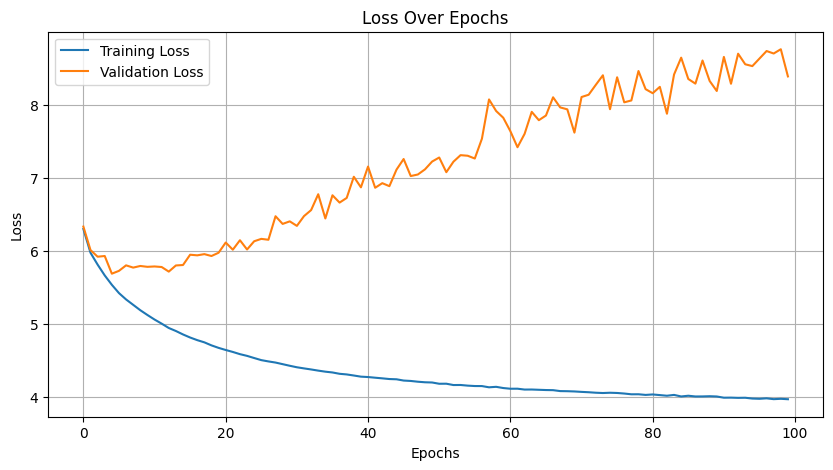

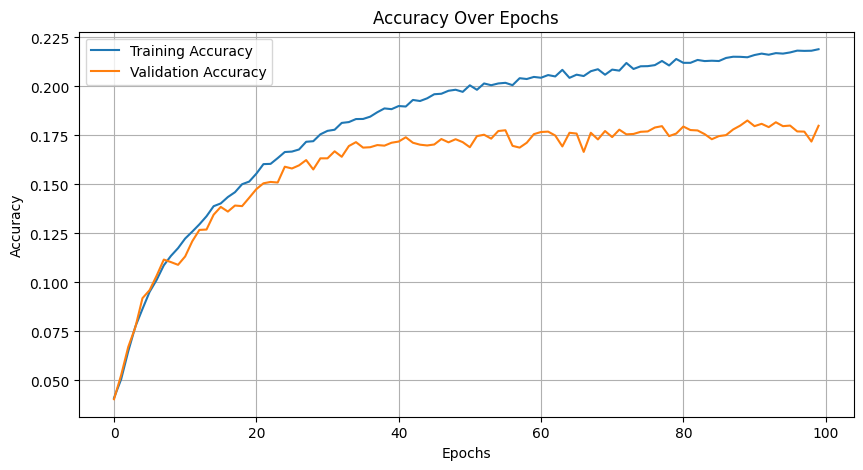

In [30]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [28]:
!pip install rouge-score bert-score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=686701325862b3dad4cc9c33487c1a3e1ea8c63a94e7ac33b9d64dd9f655c3d7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [35]:
from bert_score import score as bert_score
from rouge_score import rouge_scorer

# Function to generate predictions
def generate_responses(input_texts, model, tokenizer, max_length, num_predictions=20):
    predictions = []
    for text in input_texts:
        generated_text = predict_sequence(text, model, tokenizer, max_length, num_predictions)
        predictions.append(generated_text)
    return predictions

# Test data to evaluate
test_inputs = [
    " ".join([tokenizer.index_word.get(idx, "") for idx in seq if idx != 0])  # Exclude padding (index 0)
    for seq in X_test[:10]
]

test_targets = [
    " ".join([tokenizer.index_word.get(np.argmax(vec), "") for vec in seq if np.argmax(vec) != 0])  # Exclude padding
    for seq in y_test[:10]
]

# Remove extra spaces if any
test_inputs = [text.strip() for text in test_inputs]
test_targets = [text.strip() for text in test_targets]

# Generate predictions
generated_responses = generate_responses(test_inputs, model, tokenizer, max_length)

# BERTScore Evaluation
#P, R, F1 = bert_score(generated_responses, test_targets, lang="en", verbose=True)
P, R, F1 = bert_score(generated_responses, test_targets, model_type="roberta-base", lang="en", verbose=True)

print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall: {R.mean().item():.4f}")
print(f"BERTScore F1: {F1.mean().item():.4f}")

# ROUGE-L Evaluation
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_l_scores = [
    scorer.score(target, pred)['rougeL'].fmeasure
    for target, pred in zip(test_targets, generated_responses)
]
avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
print(f"Average ROUGE-L Score: {avg_rouge_l:.4f}")

# Display Individual Results
for i, (inp, tgt, gen) in enumerate(zip(test_inputs, test_targets, generated_responses)):
    print(f"\nExample {i+1}")
    print(f"Input: {inp}")
    print(f"Target: {tgt}")
    print(f"Generated: {gen}")
    print(f"ROUGE-L Score: {rouge_l_scores[i]:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 7188 has 14.73 GiB memory in use. Of the allocated memory 1015.24 MiB is allocated by PyTorch, and 4.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)